In [1]:
import numpy as np
import math

import torch
import torch.nn.init as init
import torch.nn.functional as F
# torch.autograd.set_detect_anomaly(True)

from scipy.special import gamma

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
np.random.seed(89)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import control as ct

from pyfod.fod import caputo
from scipy.interpolate import CubicSpline

## Fractional Order System Model

In [7]:
# order of the Caputo fractional derivative
q = 0.5

# initial states X0 = ([x1(t0), x2(t0),.. xN(t0)]), only for plotting original dynamics
initial_X_array = np.array([0.5, 0.3])
initial_X_tensor = torch.tensor([0.5, 0.3], dtype=torch.float)

# initial starting time
t0 = 0.01

# total number of time steps (= total number of solutions calculated φ(t,x0))
# final time t_{final} = t0 + num_steps*∆t
num_steps = 250

# time step size
Delta_t = 0.01

In [8]:
# controlled dynamics for the system (TENSOR)
def f_controlled(t, X, K):
    x, y = X[0], X[1]

    A = torch.tensor([[-1+a_param, -1-a_param], [1, -1]], dtype=torch.float)
    B = torch.tensor([[1], [1]], dtype=torch.float)
    # B = torch.tensor([[0], [0]], dtype=torch.float)

    # calculate the linear and controller parts (TENSOR)
    Linear = torch.matmul(A, X.unsqueeze(-1)).squeeze(-1)
    Control = torch.matmul(torch.matmul(B, K), X.unsqueeze(-1)).squeeze(-1)

    # non-linear term
    # nonLinear = torch.tensor([x1**3-0.3*x1*x2**2, 0.4*x2**3+beta*x2*(x1-x2)])

    # controlled system dynamics
    x_u = Linear[0] - Control[0] + x**3 - 0.3*x*y**2
    y_u = Linear[1] - Control[1] - 0.4*x**3 + b_param*y*(x-y)

    return torch.stack([x_u, y_u])

In [9]:
# controlled dynamics for the system (ARRAY)
def f_ce_controlled(t, X, K):
    x, y = X[0], X[1]

    A = torch.tensor([[-1+a_param, -1-a_param], [1, -1]], dtype=torch.float)
    B = torch.tensor([[1], [1]], dtype=torch.float) # if control is introduced
    # B = torch.tensor([[0], [0]], dtype=torch.float)

    Linear = np.dot(A, X)
    Control = np.dot(np.matmul(B, K), X)

    x_u = Linear[0] - Control[0] + x**3 - 0.3*x*y**2
    y_u = Linear[1] - Control[1] - 0.4*x**3 + b_param*y*(x-y)

    return np.array([x_u, y_u])

### Controller Gain Matrix $K_{lqr}$ and Lyapunov Function $V_{lqr} = \frac{1}{2} \thinspace \textbf{x}^T \thinspace P \thinspace\textbf{x} $ Derived from Solving the ARE

In [11]:
# number of state vectors
N = len(initial_X_tensor)

# system parameter(s)
a_param = 0.05
b_param = 0.2

# the matrix for the linear part of the system dynamics
A = np.array([[-1+a_param, -1-a_param], [1, -1]])

# controller acting on the non-linear part
B = np.array([[1], [1]])

In [12]:
# define the matrices Q and R
R = np.array([1])
Q = np.eye(N)

# solve for optimal control matrix K_lqr:
# S is the inverse of P, the solution of the Algebraic Riccati Equation (ARE)
# S will be used later for constructing the V_lqr function
(K_lqr, S, E) = ct.lqr(A, B, Q, R)
print("LQR Feedback matrix K_lqr: {}".format(K_lqr))

LQR Feedback matrix K_lqr: [[0.35237005 0.41608283]]


In [13]:
# solve the Algebraic Riccati Equation (ARE) and get P
# (K_lqr, S, E) = ct.lqr(A, B, Q, R) solved in a the section above
P_lqr = np.linalg.inv(S)

print('Solution of the Algebraic Riccati Equation (ARE):')
print(P_lqr)

Solution of the Algebraic Riccati Equation (ARE):
[[2.50433524 0.28250932]
 [0.28250932 2.16411763]]


## Lyapunov function $V()$ and the class-K function $\alpha()$

In [15]:
# Lyapunov function V_lqr = 1/2 X.t() P X
def V_lqr(in_P, in_x1, in_x2):
    # separate each element of P
    Pa = in_P[0][0]; Pb = in_P[0][1]
    Pc = in_P[1][0]; Pd = in_P[1][1]
    return Pa*(in_x1**2)+(Pb+Pc)*(in_x1*in_x2)+Pd*(in_x2**2)

In [16]:
# the class-K function alpha()
def alpha_func(X):
    x1, x2 = X[0], X[1]
    Aa = 2; Ab = 1
    Ac = 1; Ad = 3
    return 0.1*(Aa*(x1**2)+(Ab+Ac)*(x1*x2)+Ad*(x2**2))

In [17]:
# plot the 3d surface of V
PLOT_r = 3.5
PLOT_x1 = np.linspace(-PLOT_r, PLOT_r, 100)
PLOT_x2 = np.linspace(-PLOT_r, PLOT_r, 100)
PLOT_t = np.linspace(t0, t0+(num_steps*Delta_t), num_steps)

# two-dimensional grid (x1,x2)
x1, x2 = np.meshgrid(PLOT_x1, PLOT_x2)

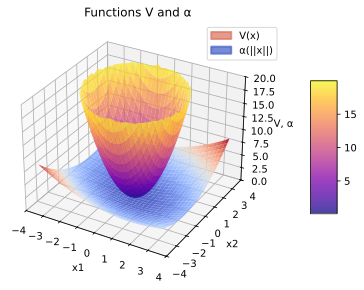

In [219]:
'''
# plot the 3d surface of V
PLOT_r = 3.5
PLOT_x1 = np.linspace(-PLOT_r, PLOT_r, 160)
PLOT_x2 = np.linspace(-PLOT_r, PLOT_r, 160)
PLOT_t = np.linspace(t0, t0+(num_steps*Delta_t), num_steps)

# two-dimensional grid (x1,x2)
x1, x2 = np.meshgrid(PLOT_x1, PLOT_x2)
'''

# Lyapunov function V_lqr (clipped for plotting 3d surface)
V_lqr_clipped = np.clip(V_lqr(P_lqr,x1,x2), -5, 20)
V_lqr_clipped[V_lqr_clipped == 20] = np.nan

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# number of values corresponding to the isocontour closest to r=eta
num_levels = 5

# the Lyapunov scalar field V_nn
V_lqr_surf = ax.plot_surface(x1, x2, V_lqr_clipped, rstride=5, cstride=5, alpha=0.75, cmap=plt.cm.plasma)
ax.set_zlim(0, 20)
fig.colorbar(V_lqr_surf, ax=ax, shrink=0.5, aspect=5, pad=0.15)

# class-Κ Function α, appears in Equation (8)
alpha_surf = ax.plot_surface(x1, x2, alpha_func([x1,x2]), rstride=5, cstride=5, alpha=0.875, cmap=plt.cm.coolwarm)
ax.set_zlim(0, 20)
# fig.colorbar(alpha_surf, ax=ax, shrink=0.4, aspect=5, pad=0.2)

ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('V, α')
# legend for the 3d plot
plt.legend([plt.Rectangle((0,0), 1, 2, color=(220/255, 120/255, 100/255, 0.75), fill=True, linewidth=2),
            plt.Rectangle((0,0), 1, 2, color=(75/255, 100/255, 200/255, 0.75), fill=True, linewidth=2)],
            ['V(x)','α(||x||)'], bbox_to_anchor=(1.08, 0.98), loc='upper right', borderaxespad=0, ncol=1)

plt.title('   Functions V and α')
plt.show()

## Numerical Solver for Computing the State Vectors

In [20]:
# compute the controlled dynamics
def fu_solver(f_ode, initial_states, K, q, t0, h, num_steps):

    # Create a zero array *sol* of size (num_steps, N)
    N = len(initial_states)
    sol = torch.zeros((num_steps+1, N)) # that's of size (num_steps, N)
    t_interval = [t0]

    # Set initial conditions
    sol[0] = initial_states

    f_t1 = f_ode(t0+h, sol[0], K)
    sol[1] = sol[0] + ((h**q)/gamma(q+1))*f_t1

    # Fractional Adams-Bashforth Method
    for k in range(1, num_steps):
        t = round(t0+k*h, 5)
        t_interval.append(t)

        sum_prev = 0
        if k > 1:
            sum_prev = (sol[k-1] - sol[k-2]) / (h**q)
        f_tk = f_ode(t, sol[k], K)

        sol[k+1] = sol[k] + ((h**q)/gamma(q+1))*(f_tk)

    return sol

## Find the Maximum ROA

The maximum ROA $\Omega$: for all $x \in \Omega$, the Lyapunov function still satisfies the conditions for asymptotic stability:

- $^{C}\hspace{-1pt}D^{α}V(x) \geq \alpha(x)$
- $^{C}\hspace{-1pt}D^{α}V(x) \leq − \mathcal{c}V(x)$

For any $x(t_0) \in \Omega$, the trajectory $x(t)$ remains within $\Omega$ and asymptotically converges to the equilibrium point.

In [22]:
n_steps = 50
converge_epsilon_neighbor = 0.1
constant_c = 0.5 

In [23]:
def is_point_in_list(array_list, target):    
    for point in array_list:
        if np.array_equal(point, target):
            return True
            
    return False

In [24]:
# plot the direction field of the controlled dynamics
def PlotDF(in_x1, in_x2, t, K, in_color):
    # phase plane of the actual dynamics, use the np version of controlled dynamics
    DF_x1 = []
    DF_x2 = []
    for i in range(len(in_x1)):
        df_x1, df_x2 = f_ce_controlled(t, [in_x1[i], in_x2[i]], K)
        DF_x1.append(df_x1)
        DF_x2.append(df_x2)
    plt.streamplot(in_x1, in_x2, np.array(DF_x1), np.array(DF_x2), color=in_color, linewidth=0.6, density=0.6, arrowstyle='-|>', arrowsize=1)

In [25]:
# computes the fractional integral of f(t) from t_a to t_a+(Delta_t*num_steps) of order q
def frac_integral(f_list, t_a, t_b, q, Delta_t):
    # f(t): function to integrate
    # t_a: lower limit of integration

    # initialize fractional integral
    If_val = 0.0

    # number of steps
    integ_steps = round((t_b-t_a)/Delta_t)

    # time steps
    t_values = np.linspace(t_a, t_b, integ_steps+1)

    # numerical integration using trapezoidal rule
    for i in range(1, integ_steps+1):  # include t_b boundary
        tau = t_values[i-1]
        tau_next_step = t_values[i]

        # avoid dividing by 0 at tau = t_b
        if i == integ_steps:
            If_val = If_val + ((t_b-tau)**(q-1)*(f_list[i-1])) * Delta_t / 2

        else:
            # trapezoidal rule: average of two consecutive points; integrand: (-f_list(tau)) / (t_b-tau)^(alpha)
            If_val = If_val + ((t_b-tau)**(q-1)*(f_list[i-1]) + (t_b-tau_next_step)**(q-1)*(f_list[i])) * Delta_t / 2

    If_val = If_val / gamma(1+q)

    return If_val

In [235]:
searching_range[0][0]

-3.5

In [231]:
searching_range[1]

array([-3.42929293, -3.5       ])

In [227]:
searching_range

array([[-3.5       , -3.5       ],
       [-3.42929293, -3.5       ],
       [-3.35858586, -3.5       ],
       ...,
       [ 3.35858586,  3.5       ],
       [ 3.42929293,  3.5       ],
       [ 3.5       ,  3.5       ]])

### Find the `x0` which Satisfies `Condition_1`: $^{C}\hspace{-1pt}D^{α}V(x)≤−cV$

In [27]:
V_RoA = []
Actual_RoA = []

square_range = np.column_stack((x1.ravel(), x2.ravel()))
searching_range = []

for x1x2 in square_range:
    if math.sqrt(x1x2[0]**2 + x1x2[1]**2) <= PLOT_r:
        searching_range = []

for x0 in searching_range:
    x0_tensor = torch.tensor(x0, dtype=torch.float)
    t_interval = np.linspace(t0, t0+(n_steps*Delta_t), n_steps+1)
    sol = fu_solver(f_controlled, x0_tensor, torch.tensor(K_lqr, dtype=torch.float), q, t0, Delta_t, n_steps)

    # the solution converges
    if torch.sqrt(torch.pow(sol[-1][0],2) + torch.pow(sol[-1][1],2)).item() <= converge_epsilon_neighbor:
        Actual_RoA.append(x0)
        V_val_list = [V_lqr(P_lqr, x0[0], x0[1])]
        
        i = 1
        condition1 = True

        for xt in sol[1:]:
            V_val = V_lqr(P_lqr, xt[0], xt[1]).item()
            V_val_list.append(V_val)
            
            t_start = t_interval[0]
            t_current = t_interval[i]
            # D_V = frac_derivative(t_current, Delta_t, V_val_list, q)
            
            t_sublist = t_interval[:i+1]
            V_t = CubicSpline(t_sublist, V_val_list, bc_type='natural')
            CaputoDic_V = caputo(f=V_t, alpha=q, lower=t_start, upper=t_current, quadrature='rs', n=200)
            D_V = CaputoDic_V['fd']

            # test for the condition: ^{C}D^{α}V(x)≤−cV
            if D_V > (-constant_c)*V_val_list[-1]:
                condition1 = False     

            i = i + 1
            
        if condition1 == True:
            V_RoA.append(x0)

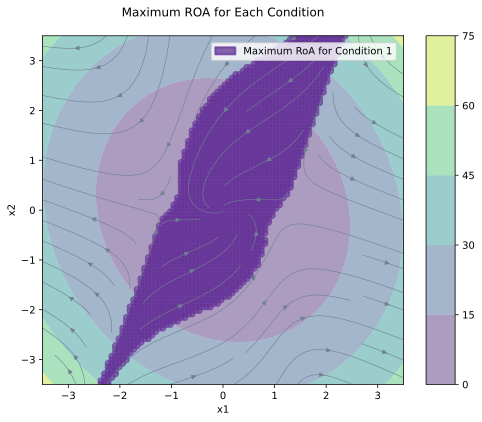

In [209]:
# V(x)=C contour line 
plt.figure(figsize=(6.75*1.2, 5.25*1.2))
ax = plt.gca()

cset_V = ax.contourf(x1, x2, V_lqr(P_lqr, x1, x2), 4, alpha=0.45, cmap=plt.cm.viridis)
plt.colorbar(cset_V, ax=ax, shrink=1, aspect=12, pad=0.05)

# plot the direction field
PlotDF(x1, x2, PLOT_t, K_lqr, 'slategrey')

# plt.clabel(contour, inline=True, fontsize=10)
# plt.title('Level Set of V(x) = {}'.format(round(max_contour_C,3)))

xv_coords = [point[0] for point in V_RoA]
yv_coords = [point[1] for point in V_RoA]

plt.scatter(xv_coords, yv_coords, c='rebeccapurple', alpha=0.65)

plt.title('Maximum ROA for Each Condition\n')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# legend for the 3d plot
plt.legend([plt.Rectangle((0,0), 1, 2, color=(100/255, 50/255, 150/255, 0.75), fill=True, linewidth=2)],
            ['Maximum RoA for Condition 1'], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0, ncol=1)

plt.xlabel('x1')
plt.ylabel('x2')
# plt.grid(True)
plt.show()

# **W_NN for Learning the Positive Definite Function W(t)**

In [30]:
class W_Net(torch.nn.Module):
    def __init__(self, N):
        super(W_Net, self).__init__()

        # number of elements in the upper triangular matrix of A
        num_ut = 0
        for i in range(N+1):
            num_ut = num_ut + i

        # elements in the upper triangular, initialized to random integers
        param = [np.random.randint(-10,10) for _ in range(num_ut)]

        # multiply diagonal elements by 2 for better initialization (Positive Defininte)
        # diagonal_index = []

        # i_sum = 1
        # for i in range(N,0,-1):
            # diagonal_index.append(i_sum)
            # i_sum = i_sum + i

        # for index in diagonal_index:
            # param[index-1] = param[index-1]*2

        self.weight = torch.nn.Parameter(torch.tensor(param, dtype=torch.float), requires_grad=True)

    def forward(self, input_x):
        weight_no_grad = self.weight.clone().detach().numpy()

        mat_A = np.zeros((N,N))
        

        n = 0
        for i in range(N):
            for j in range(i,N):
                mat_A[i,j] = weight_no_grad[n]
                n = n + 1

        mat_A = torch.tensor(np.transpose(mat_A), dtype=torch.float)
        # making the mat a complete symmetric matrix

        ut_index = 0
        for i in range(N):
            for j in range(i,N):
                mat_A[i,j] = self.weight[ut_index] # keep the ut elements in A update-able
                ut_index = ut_index + 1

        # W(t) = x^T * mat_A * x
        W = torch.matmul(torch.matmul(input_x, mat_A), input_x.reshape(-1,1))

        return W, mat_A

In [31]:
# define the NN model and the weight optimizer
N = len(initial_X_tensor)
learning_rate_W = 0.5

W_model = W_Net(N)
optimizer = torch.optim.Adam(W_model.parameters(), lr=learning_rate_W)

## **Function W and 3d Surface Plot** 

In [33]:
# Lyapunov function W = X.t() mat_A X
def W_func(in_A, in_x1, in_x2):
    # separate each element of P
    Aa = in_A[0][0]; Ab = in_A[0][1]
    Ac = in_A[1][0]; Ad = in_A[1][1]
    return Aa*(in_x1**2)+(Ab+Ac)*(in_x1*in_x2)+Ad*(in_x2**2)

In [34]:
def Plot_W(input_A):
    # transform A from tensor to numpy
    A_np = input_A.detach().numpy()

    # plot the 3d surface
    PLOT_r = 5
    PLOT_x1 = np.linspace(-PLOT_r, PLOT_r, 200)
    PLOT_x2 = np.linspace(-PLOT_r, PLOT_r, 200)

    # two-dimensional grid (x1,x2)
    x1, x2 = np.meshgrid(PLOT_x1, PLOT_x2)

    # Lyapunov function V (clipped for plotting 3d surface near the equilibrium)
    # V_clipped = np.clip(V_nn(x1, x2), -5, 35)
    # V_clipped[V_clipped == 35] = np.nan

    # Poositive Definite function W (also clipped)
    W_clipped = np.clip(W_func(A_np, x1, x2), -5, 35)
    W_clipped[W_clipped == 35] = np.nan

    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++

    fig = plt.figure(figsize=(9,4.5))
    ax = fig.add_subplot(111, projection='3d')

    # the Lyapunov scalar field V_nn
    W_surf = ax.plot_surface(x1, x2, W_clipped, rstride=5, cstride=5, alpha=0.55, cmap=plt.cm.winter)
    ax.set_zlim(0, 35)
    fig.colorbar(W_surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

    # valid region
    theta = np.linspace(0, 2*np.pi, 200)
    Valid_x1 = eta_W*np.cos(theta)
    Valid_x2 = eta_W*np.sin(theta)
    ax.plot(Valid_x1[:], Valid_x2[:], 'black', linestyle='--', linewidth=2, label='B(η)')
    plt.legend()

    ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('W')
    plt.title('                 Positive Definite Function W \n', fontsize=16)

    plt.show()

# **Main Function for Finding W**

In [36]:
# count on the current iteration
itera_W = 0

# maximum number of learning/training iterations
max_iter_W = 1000

# final time
t_final = t0 + (num_steps*Delta_t)

# indicating W's validity
W_valid = False

# for checking model loss and eig(A) duing the entire learning process
losses_W = []
min_eig_A_vals = []

# radius of the neighborhood (just for plotting W)
eta_W = 2 

# batch_size
batch_size = 100

In [37]:
def is_tensor_in_list(tensor_list, target):
    # tensor = tensor.to('cpu')
    for tensor in tensor_list:
        # tensor = tensor.to('cpu')
        if torch.equal(tensor, target):
            return True
            
    return False

In [38]:
len(V_RoA)

2427

In [39]:
X0_Learn = []

# the points are too close and dense, only take 10% as the initial input
for i in range(len(V_RoA)):
    if i%10==0:
        X0_Learn.append(torch.tensor(V_RoA[i], dtype=torch.float))

In [40]:
len(X0_Learn)

243


Iteration 0 : Min(eig(A)): -0.7082 , Model loss: 490.42035


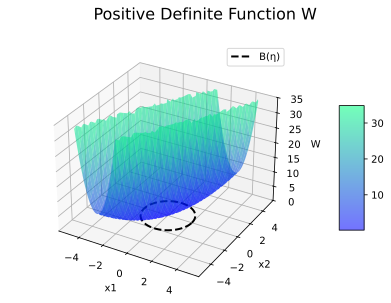


Iteration 10 : Min(eig(A)): 2.46991 , Model loss: 192.78595


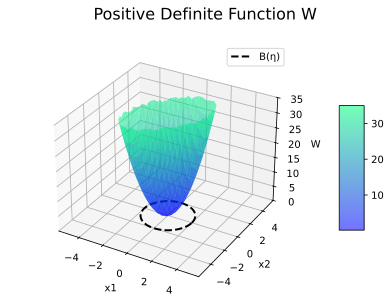


Iteration 20 : Min(eig(A)): 2.52392 , Model loss: 2.64386


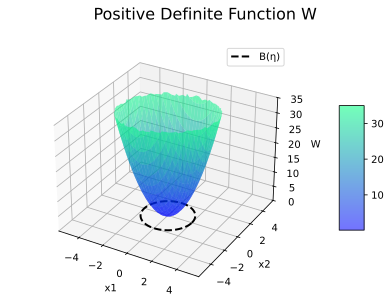

============================== SIMULATION DONE ==============================

Iteration 25 : Min(eig(A)): 1.78839 , Model loss: 0.0


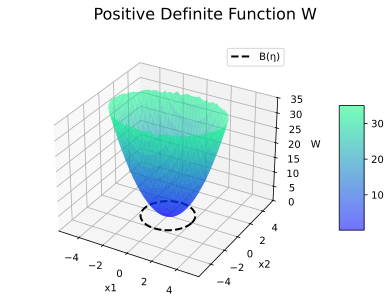

In [41]:
while itera_W <= max_iter_W and not W_valid:
    # random starting points within the neighborhood
    min_eig_A = torch.tensor(0, dtype=torch.float)
    loss = 0
    
    # start with initial list of `batch_size` randomly chosen initial states from the annulus as the inputs
    random_X0_Learn = []

    for _ in range(batch_size):
        random_index = np.random.randint(0,len(V_RoA))
        random_X0_Learn.append(torch.tensor(V_RoA[random_index], dtype=torch.float)) 

    X0_Learn = X0_Learn + random_X0_Learn
    
    for x0 in X0_Learn:
        # calculate the solutions x(t0) to x(t_final)
        t_interval = np.linspace(t0, t0+(n_steps*Delta_t), n_steps+1)
        sol = fu_solver(f_controlled, x0, torch.tensor(K_lqr, dtype=torch.float), q, t0, Delta_t, n_steps)

        V_temp0_val = V_lqr(P_lqr, x0[0], x0[1])
        V_val_list = [V_temp0_val]
        W_temp0_val, mat_A = W_model(x0)
        W_val_list = [W_temp0_val]

        i = 1
        # V_val is valid already as the set used is the valid set
        for x_t in sol[1:]:
            V_val = V_lqr(P_lqr, x_t[0], x_t[1])
            V_val_list.append(V_val)
            W_val, mat_A = W_model(x_t)
            W_val_list.append(W_val)

            # A must be positive definite
            # all eigenvalues of A should be greater than 0 (for positive definite square matrix)
            min_eig_A = torch.min(torch.linalg.eigvals(mat_A).real)
                
            t_current = t_interval[i]
            t_sublist = t_interval[:i+1]
            V_t = CubicSpline(t_sublist, V_val_list, bc_type='natural')
            CaputoDict_V = caputo(f=V_t, alpha=q, lower=t0, upper=t_current, quadrature='rs', n=200)
            # cD_V = frac_derivative(t_current, Delta_t, V_val_list, q)
            cD_V = CaputoDict_V['fd']

            neg_W_val_list = [-elem for elem in W_val_list]
            I_neg_W = frac_integral(neg_W_val_list, t0, t_current, 1-q, Delta_t)

            # model loss
            loss = loss + torch.max(torch.tensor(0, dtype=torch.float), (cD_V-I_neg_W))
            i = i + 1
            
    # loss for each iteration
    loss = loss + (torch.max(torch.tensor(0, dtype=torch.float), -min_eig_A))*500

    # save and plot the model loss
    losses_W.append(loss.item())
    min_eig_A_vals.append(min_eig_A.detach().numpy())

    if loss <= 0:
        W_valid = True
        # break;
        print('============================== SIMULATION DONE ==============================')

    else:
        # backward propagation, updating parameter;
        # use the SMT solver to add more x0 which does not satisfy the conditions (Counterexamples, ce)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
        new_X0_Learn = []
        
        # find a counterexample CE to be added to the input list 
        for ce_chosen in V_RoA:
            ce_x0_chosen = torch.tensor(ce_chosen, dtype=torch.float)
            # not in the input list
            if is_tensor_in_list(X0_Learn, ce_x0_chosen) == False:
                # calculate the same things for ce candidates
                ce_t_interval = np.linspace(t0, t0+(n_steps*Delta_t), n_steps+1)
                ce_sol = fu_solver(f_controlled, ce_x0_chosen, torch.tensor(K_lqr, dtype=torch.float), q, t0, Delta_t, n_steps)
            
                ce_V_temp0_val = V_lqr(P_lqr, ce_x0_chosen[0], ce_x0_chosen[1])
                ce_V_val_list = [ce_V_temp0_val]
                ce_W_temp0_val, mat_A = W_model(ce_x0_chosen)
                ce_W_val_list = [W_temp0_val]
    
                for ce_x_t in ce_sol[1:]:
                    ce_V_val = V_lqr(P_lqr, ce_x_t[0], ce_x_t[1])
                    ce_V_val_list.append(ce_V_val)
                    
                    ce_W_val, mat_A = W_model(ce_x_t)
                    ce_W_val_list.append(ce_W_val)

                ce_t_current = ce_t_interval[n_steps]
                ce_t_sublist = ce_t_interval[:n_steps+1]

                ce_V_t = CubicSpline(ce_t_sublist, ce_V_val_list, bc_type='natural')
                ce_CaputoDict_V = caputo(f=ce_V_t, alpha=q, lower=ce_t_interval[0], upper=ce_t_current, quadrature='rs', n=200)
                # cD_V = frac_derivative(t_current, Delta_t, V_val_list, q)
                ce_cD_V = ce_CaputoDict_V['fd']
                
                ce_neg_W_val_list = [-elem for elem in ce_W_val_list]
                ce_I_neg_W = frac_integral(ce_neg_W_val_list, t0, ce_t_current, 1-q, Delta_t)
    
                # print('Current ce_x0:', ce_x0_chosen, '; Current Inequality (ce_cD_V<=ce_I_neg_W):', ce_cD_V<=ce_I_neg_W )

                # condition is not satisfied: add the counterexample to the list of inputs
                if (ce_cD_V<=ce_I_neg_W) == False:
                    X0_Learn.append(ce_x0_chosen)
                    break;
                else:
                    pass


    if itera_W%10==0 or W_valid==True:
        print('')
        print('Iteration', itera_W, ': Min(eig(A)):', round(min_eig_A.item(),5) ,', Model loss:', round(loss.item(),5))
        Plot_W(mat_A)

    itera_W = itera_W + 1

In [42]:
mat_A

tensor([[ 1.8032, -0.1588],
        [-0.1588,  3.4946]], grad_fn=<CopySlices>)

### Find the `x0` which Satisfies  `Condition_2` Only:  $^{C}\hspace{-1pt}D^{α}V(x) ≤ \hspace{1pt} ^{C}\hspace{-1pt}I(−W(x))$

In [45]:
W_RoA = []
V_RoA = []

# actual region of attraction of the system
Actual_RoA = []

searching_range = np.column_stack((x1.ravel(), x2.ravel()))

for x0 in searching_range:
    x0_tensor = torch.tensor(x0, dtype=torch.float)
    t_interval = np.linspace(t0, t0+(n_steps*Delta_t), n_steps+1)
    sol = fu_solver(f_controlled, x0_tensor, torch.tensor(K_lqr, dtype=torch.float), q, t0, Delta_t, n_steps)

    # the solution converges
    if torch.sqrt(torch.pow(sol[-1][0],2) + torch.pow(sol[-1][1],2)).item() <= converge_epsilon_neighbor:
        Actual_RoA.append(x0)

        V_val_list = [V_lqr(P_lqr, x0[0], x0[1])]
        W_val_list = [W_func(mat_A, x0[0], x0[1])]
        
        i = 1
        condition1 = True
        condition2 = True
        
        for xt in sol[1:]:
            V_val = V_lqr(P_lqr, xt[0], xt[1]).item()
            W_val = W_func(mat_A, xt[0], xt[1]).item()
            
            V_val_list.append(V_val)
            W_val_list.append(W_val)
            
            t_start = t_interval[0]
            t_current = t_interval[i]
            # D_V = frac_derivative(t_current, Delta_t, V_val_list, q)
            
            t_sublist = t_interval[:i+1]
            V_t = CubicSpline(t_sublist, V_val_list, bc_type='natural')
            CaputoDic_V = caputo(f=V_t, alpha=q, lower=t_start, upper=t_current, quadrature='rs', n=200)
            D_V = CaputoDic_V['fd']

            neg_W_val_list = [-elem for elem in W_val_list]
            I_neg_W = frac_integral(neg_W_val_list, t0, t_current, 1-q, Delta_t)

            # test for the condition: ^{C}D^{α}V(x)≤−cV
            if D_V > (-constant_c)*V_val_list[-1]:
                condition1 = False     

            if D_V > I_neg_W:
                condition2 = False

            i = i + 1
            
        if condition1 == True:
            V_RoA.append(x0)
            
        if condition2 == True:
            W_RoA.append(x0)

In [50]:
only2_not1 = []

for x0 in searching_range:
    x0_tensor = torch.tensor(x0, dtype=torch.float)
    t_interval = np.linspace(t0, t0+(n_steps*Delta_t), n_steps+1)
    sol = fu_solver(f_controlled, x0_tensor, torch.tensor(K_lqr, dtype=torch.float), q, t0, Delta_t, n_steps)

    # the solution converges
    if torch.sqrt(torch.pow(sol[-1][0],2) + torch.pow(sol[-1][1],2)).item() <= converge_epsilon_neighbor:

        V_val_list = [V_lqr(P_lqr, x0[0], x0[1])]
        W_val_list = [W_func(mat_A, x0[0], x0[1])]
        
        i = 1
        condition1 = True
        condition2 = True
        
        for xt in sol[1:]:
            V_val = V_lqr(P_lqr, xt[0], xt[1]).item()
            W_val = W_func(mat_A, xt[0], xt[1]).item()
            
            V_val_list.append(V_val)
            W_val_list.append(W_val)
            
            t_start = t_interval[0]
            t_current = t_interval[i]
            # D_V = frac_derivative(t_current, Delta_t, V_val_list, q)
            
            t_sublist = t_interval[:i+1]
            V_t = CubicSpline(t_sublist, V_val_list, bc_type='natural')
            CaputoDic_V = caputo(f=V_t, alpha=q, lower=t_start, upper=t_current, quadrature='rs', n=200)
            D_V = CaputoDic_V['fd']

            neg_W_val_list = [-elem for elem in W_val_list]
            I_neg_W = frac_integral(neg_W_val_list, t0, t_current, 1-q, Delta_t)

            # test for the condition: ^{C}D^{α}V(x)≤−cV
            if D_V > (-constant_c)*V_val_list[-1]:
                condition1 = False     

            if D_V > I_neg_W:
                condition2 = False

            i = i + 1
            
        if condition1 == True:
            if condition2 == True:
                pass
                # print(x0,'Converges towards the Origin, Both Conditions are Satisfied')
            if condition2 != True:
                print('Trajectories Starting from', x0,'Converges towards the Origin; Only Condition 1 is Satisfied')

        elif condition1 == False:
            if condition2 == True:
                print('Trajectories Starting from', x0,'Converges towards the Origin; Only Condition 2 is Satisfied')
                only2_not1.append(x0)
            if condition2 != True:
                pass
                # print(x0,'Converges towards the Origin, None of the Conditions are Satisfied')

Trajectories Starting from [ 0.81313131 -0.74242424] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.81313131 -0.53030303] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.88383838 -0.53030303] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.88383838 -0.45959596] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.88383838 -0.38888889] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.88383838 -0.31818182] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.95454545 -0.31818182] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.95454545 -0.24747475] Converges towards the Origin; Only Condition 2 is Satisfied
Trajectories Starting from [ 0.95454545 -0.17676768] Converges towards the Origin; Only Conditio

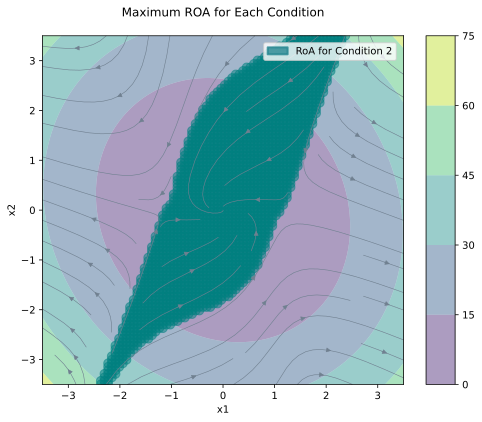

In [215]:
# V(x)=C contour line 
plt.figure(figsize=(6.75*1.2, 5.25*1.2))
ax = plt.gca()

cset_V = ax.contourf(x1, x2, V_lqr(P_lqr, x1, x2), 4, alpha=0.45, cmap=plt.cm.viridis)
plt.colorbar(cset_V, ax=ax, shrink=1, aspect=12, pad=0.05)

# contour = ax.contour(x1, x2, V_values, levels=[0.01], linewidths=1.5, cmap=plt.cm.viridis)

# plot the direction field
PlotDF(x1, x2, PLOT_t, K_lqr, 'slategrey')

# plt.clabel(contour, inline=True, fontsize=10)
# plt.title('Level Set of V(x) = {}'.format(round(max_contour_C,3)))

xw_coords = [point[0] for point in W_RoA]
yw_coords = [point[1] for point in W_RoA]

plt.scatter(xw_coords, yw_coords, c='teal', alpha=0.5, s=80)

plt.title('Maximum ROA for Each Condition\n')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# legend for the 3d plot
plt.legend([plt.Rectangle((0,0), 1, 2, color=(30/255, 130/255, 140/255, 0.75), fill=True, linewidth=2)],
            ['RoA for Condition 2'], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0, ncol=1)

plt.xlabel('x1')
plt.ylabel('x2')
# plt.grid(True)
plt.show()

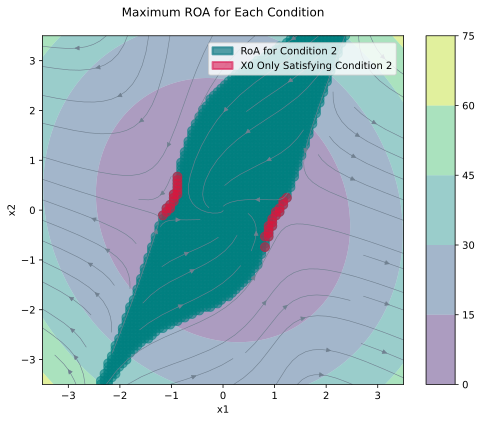

In [217]:
# V(x)=C contour line 
plt.figure(figsize=(6.75*1.2, 5.25*1.2))
ax = plt.gca()

cset_V = ax.contourf(x1, x2, V_lqr(P_lqr, x1, x2), 4, alpha=0.45, cmap=plt.cm.viridis)
plt.colorbar(cset_V, ax=ax, shrink=1, aspect=12, pad=0.05)

# contour = ax.contour(x1, x2, V_values, levels=[0.01], linewidths=1.5, cmap=plt.cm.viridis)

# plot the direction field
PlotDF(x1, x2, PLOT_t, K_lqr, 'slategrey')

# plt.clabel(contour, inline=True, fontsize=10)
# plt.title('Level Set of V(x) = {}'.format(round(max_contour_C,3)))

xw_coords = [point[0] for point in W_RoA]
yw_coords = [point[1] for point in W_RoA]

plt.scatter(xw_coords, yw_coords, c='teal', alpha=0.55, s=80)

x2n1_coords = [point[0] for point in only2_not1]
y2n1_coords = [point[1] for point in only2_not1]

plt.scatter(x2n1_coords, y2n1_coords, c='crimson', alpha=0.55, s=80)

plt.title('Maximum ROA for Each Condition\n')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# legend for the 3d plot
plt.legend([plt.Rectangle((0,0), 1, 2, color=(30/255, 130/255, 140/255, 0.75), fill=True, linewidth=2),
           plt.Rectangle((0,0), 1, 2, color=(220/255, 40/255, 95/255, 0.65), fill=True, linewidth=2)],
            ['RoA for Condition 2', 'X0 Only Satisfying Condition 2'], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0, ncol=1)

plt.xlabel('x1')
plt.ylabel('x2')
# plt.grid(True)
plt.show()

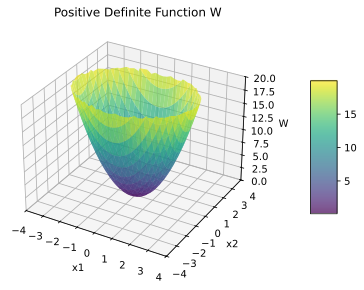

In [93]:
# plot the 3d surface of W
PLOT_r = 3.5
PLOT_x1 = np.linspace(-PLOT_r, PLOT_r, 160)
PLOT_x2 = np.linspace(-PLOT_r, PLOT_r, 160)
PLOT_t = np.linspace(t0, t0+(num_steps*Delta_t), num_steps)

# two-dimensional grid (x1,x2)
x1, x2 = np.meshgrid(PLOT_x1, PLOT_x2)

# Lyapunov function V_lqr (clipped for plotting 3d surface)
W_clipped = np.clip(W_func(mat_A.detach().numpy(), x1, x2), -5, 20)
W_clipped[W_clipped == 20] = np.nan

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# number of values corresponding to the isocontour closest to r=eta
num_levels = 5

# the Lyapunov scalar field V_nn
W_surf = ax.plot_surface(x1, x2, W_clipped, rstride=5, cstride=5, alpha=0.7, cmap=plt.cm.viridis)
ax.set_zlim(0, 20)
fig.colorbar(W_surf, ax=ax, shrink=0.5, aspect=5, pad=0.15)

ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('W')
# legend for the 3d plot
# plt.legend([plt.Rectangle((0,0), 1, 2, color=(100/255, 200/255, 165/255, 0.95), fill=True, linewidth=2)],
#             ['Positive Definite Function W(x)'], bbox_to_anchor=(1.08, 0.98), loc='upper right', borderaxespad=0, ncol=1)

plt.title('   Positive Definite Function W')
plt.show()